# Introduction to Data Science
## Homework 3

Student Name: Rong Feng

Student Netid: rf1316
***

### Part 1 (5 Points)
Assume that $X$ and $Y$ are discrete random variables. The formulas for Mutual Information, Entropy and Conditional Entropy are given by:

$$\text{Mutual Information} = \sum_{y \in Y} \sum_{x \in X} p(x, y) \cdot log\frac{p(x, y)}{p(x)p(y)}$$

$$\text{Entropy} = H(Y) = -\sum_{y \in Y} p(y) \cdot log(p(y))$$

$$\text{Conditional Entropy} = H(Y \mid X) = \sum_{x \in X} p(x) \cdot H(Y \mid X = x)$$

Show mathematically that $\text{Mutual Information} = \text{Information Gain}$, where $\text{Information Gain} = H(Y) – H(Y \mid X)$. Give the derivation below (note, this can be done using Latek math notation, which renders nicely. See above. Feel free to do it by hand and submit an image of your proof).

Place your answer here!

We will show that $\text{Mutual Information} + H(Y \mid X) = H(Y)$

$$ H(Y \mid X) = \sum_{x \in X} p(x) \cdot H(Y \mid X = x) = 
- \sum_{x \in X} p(x) \sum_{y \in Y} p(y \mid x) \cdot log(p(y \mid x)) \\
\text{ by definition}$$

$$ = - \sum_{x \in X} \sum_{y \in Y} p(x, y) \cdot log(p(y \mid x)) 
= - \sum_{x \in X} \sum_{y \in Y} p(x, y) \cdot log(\frac{p(x,y)}{p(x)}) \\
\text{ since } p(x) \cdot p(y \mid x) = p(x,y)$$

$$ = \sum_{x \in X} \sum_{y \in Y} p(x, y) \cdot log(\frac{p(x)}{p(x,y)}) 
= \sum_{y \in Y} \sum_{x \in X} p(x, y) \cdot log(\frac{p(x)}{p(x,y)})\\
\text{by flipping the log and the sum order}$$

$$ \text{then} \\
\text{Mutual Information} + H(Y \mid X) =
\sum_{y \in Y} \sum_{x \in X} p(x, y) \cdot log\frac{p(x, y)}{p(x)p(y)} + 
\sum_{y \in Y} \sum_{x \in X} p(x, y) \cdot log(\frac{p(x)}{p(x,y)}) 
$$

$$ = \sum_{y \in Y} \sum_{x \in X} p(x, y) \cdot
log\frac{p(x, y) \cdot p(x)}{p(x)p(y) \cdot p(x,y)} $$

$$ = \sum_{y \in Y} \sum_{x \in X} p(x, y) \cdot log\frac{1}{p(y)}
= - \sum_{y \in Y} \sum_{x \in X} p(x, y) \cdot log(p(y))$$

$$ = - \sum_{y \in Y} log(p(y)) \sum_{x \in X} p(x) p(y \mid x) \\
\text{since } p(x,y) = p(y \mid x) \cdot p(x)
$$

$$ = -\sum_{y \in Y} p(y) \cdot log(p(y)) = H(Y) \\
\text{since } \sum_{x \in X} p(x) p(y \mid x) = p(y) \\
\text{QED}
$$

### Part 2 - Preparing a Training Set and Training a Decision Tree (10 Points)
This is a hands-on task where we build a predictive model using Decision Trees discussed in class. For this part, we will be using the data in `cell2cell_data.csv`.

These historical data consist of 39,859 customers: 19,901 customers that churned (i.e., left the company) and 19,958 that did not churn (see the `"churndep"` variable). Here are the data set's 11 possible predictor variables for churning behavior: 

```
Pos.  Var. Name  Var. Description
----- ---------- --------------------------------------------------------------
1     revenue    Mean monthly revenue in dollars
2     outcalls   Mean number of outbound voice calls
3     incalls    Mean number of inbound voice calls
4     months     Months in Service
5     eqpdays    Number of days the customer has had his/her current equipment
6     webcap     Handset is web capable
7     marryyes   Married (1=Yes; 0=No)
8     travel     Has traveled to non-US country (1=Yes; 0=No)
9     pcown      Owns a personal computer (1=Yes; 0=No)
10    creditcd   Possesses a credit card (1=Yes; 0=No)
11    retcalls   Number of calls previously made to retention team
```

The 12th column, the dependent variable `"churndep"`, equals 1 if the customer churned, and 0 otherwise. 

1\. Load the data and prepare it for modeling. Note that the features are already processed for you, so the only thing needed here is split the data into training and testing. Use pandas to create two data frames: train_df and test_df, where train_df has 80% of the data chosen uniformly at random without replacement (test_df should have the other 20%). Also, make sure to write your own code to do the splits. You may use any random() function numpy but DO NOT use the data splitting functions from Sklearn.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [2]:
meta = """
Pos.  Var. Name  Var. Description
----- ---------- --------------------------------------------------------------
1     revenue    Mean monthly revenue in dollars
2     outcalls   Mean number of outbound voice calls
3     incalls    Mean number of inbound voice calls
4     months     Months in Service
5     eqpdays    Number of days the customer has had his/her current equipment
6     webcap     Handset is web capable
7     marryyes   Married (1=Yes; 0=No)
8     travel     Has traveled to non-US country (1=Yes; 0=No)
9     pcown      Owns a personal computer (1=Yes; 0=No)
10    creditcd   Possesses a credit card (1=Yes; 0=No)
11    retcalls   Number of calls previously made to retention team
"""

cols = [x.split()[1] for x in meta.split("\n")[3:-1]]
cols.append('churndep')
print(cols)

['revenue', 'outcalls', 'incalls', 'months', 'eqpdays', 'webcap', 'marryyes', 'travel', 'pcown', 'creditcd', 'retcalls', 'churndep']


In [3]:
# read the file into the dataframe
df = pd.read_csv("cell2cell_data.csv", header=None, names=cols)

In [4]:
pct_train = 0.8  # parameter
num_train = round(df.shape[0] * pct_train)
num_test = df.shape[0] - num_train

test_idx = np.random.choice(np.arange(0,df.shape[0]), num_test)
assert num_test == len(test_idx)  # makes sure we have the same number of test indices

In [5]:
test_df = df.iloc[test_idx]
train_df = df[~df.index.isin(test_df.index)]
print("training length %s" % len(train_df), "\ntest length %s" % len(test_df))

training length 32636 
test length 7972


In [6]:
# let's make sure we have no data overlap
assert len(train_df[[]].join(test_df[[]], how='inner')) == 0

#### Great!, can now continue to the next step

2\. If we had to, how would we prove to ourselves or a colleague that our data was indeed randomly sampled on X? And by prove, I mean empirically, not just showing this person our code. Don't actually do the work, just describe in your own words a test you could here. Hint: think about this in terms of selection bias and use notes from our 2nd lecture.

We can sample multiple times using our methodology, then compare the sampled distributions of our multiple sampled data and make sure that they are all similar.

If we have informations about X, we can do statistical testing of various distributional metrics of our sample against that of X. For example testing whether the means are statistically different.

Finally to double check that the sampling routine was random, we can check the sampled indices and confirm they are uniformly distributed on [0:len(data)]

3\. Now build and train a decision tree classifier using `DecisionTreeClassifier()` [(manual page)](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) on train_df to predict the `"churndep"` target variable. Make sure to use `criterion='entropy'` when instantiating an instance of `DecisionTreeClassifier()`. For all other settings you should use all of the default options.

In [7]:
X = train_df.drop('churndep', 1)
Y = train_df['churndep']
X_test = test_df.drop('churndep',1)
Y_test = test_df['churndep']

In [8]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X, Y)
cvs = cross_val_score(clf, X, Y, cv=10)
print(cvs)

[0.46370597 0.25359877 0.18621746 0.18602513 0.20931658 0.26570641
 0.25436715 0.34446828 0.38308305 0.52497702]


In [9]:
predicted = clf.predict(X_test)
num_corr = (predicted == Y_test).sum()
print("Test Accuracy = %.1f%%" % float(num_corr / len(predicted) * 100))

Test Accuracy = 53.5%


4\. Using the resulting model from 2.3, show a bar plot of feature names and their feature importance (hint: check the attributes of the `DecisionTreeClassifier()` object directly in IPython or check the manual!). Make sure the bar plot is sorted by increasing feature importance values.

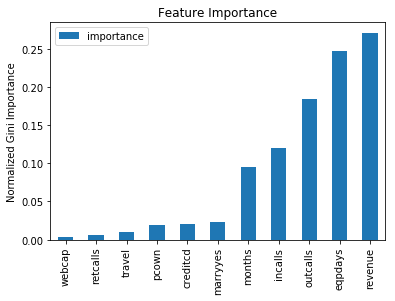

In [10]:
df_imp = pd.DataFrame(dict(zip(cols, clf.feature_importances_)), index=['importance']).T.sort_values('importance')
df_imp.plot.bar()
plt.title('Feature Importance')
plt.ylabel('Normalized Gini Importance')
plt.show()

5\. Is the relationship between the top 3 most important features (as measured here) negative or positive? If your marketing director asked you to explain the top 3 drivers of churn, how would you interpret the relationship between these 3 features and the churn outcome? What "real-life" connection can you draw between each variable and churn? Make sure to state your answer, and not just show code.

In [11]:
# code from Lab session
def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    return roc_auc

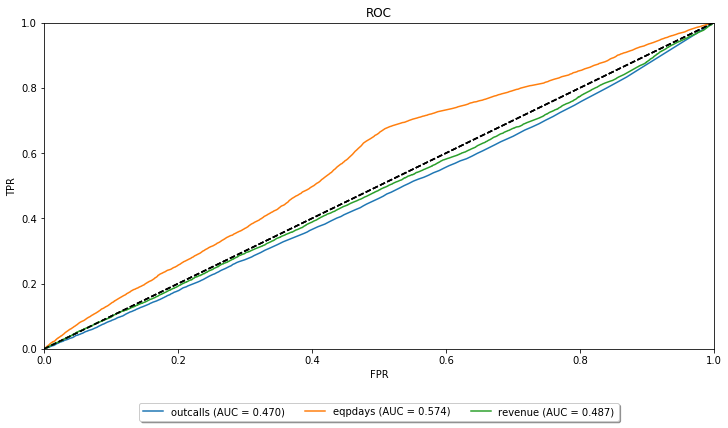

In [12]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

feature_auc_dict = {}
for col in df_imp[-3:].index.values:
    feature_auc_dict[col] = plotUnivariateROC(X[col], Y, col)
    
# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})
plt.show()

### Student Answer

Using the AUC methodology, since the AUC of outcalls and revenue < 0.5, we would think that they are negatively related with churn, and eqpdays having AUC > 0.5, is positively related with churn

We can confirm with single variate logistic regressions below:

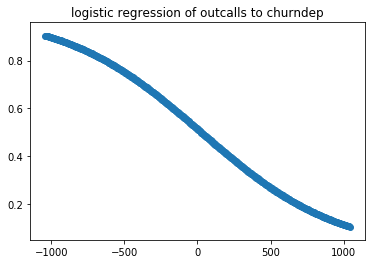

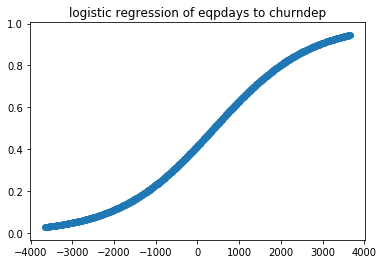

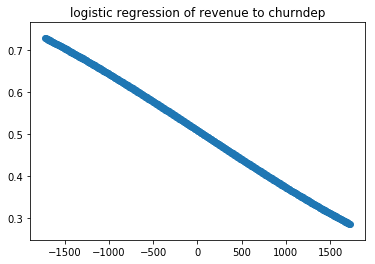

In [13]:
for col in df_imp[-3:].index.values:
    lr = LogisticRegression(C=10**-2)
    lr.fit(X[col].values.reshape(-1, 1), Y)
    descr = X[col].describe()
    x_min = descr['min']
    x_max = descr['max']
    if abs(x_min) > abs(x_max):
        x_lims = (-abs(x_min), abs(x_min))
    else:
        x_lims = (-abs(x_max), abs(x_max))
    lr_x = np.linspace(x_lims[0]*2, x_lims[1]*2, 500).reshape(-1, 1)
    lr_predicted = lr.predict_proba(lr_x)
    plt.scatter(lr_x, lr_predicted[:,1])
    plt.title("logistic regression of %s to churndep" % col)
    plt.show()

In [16]:
# we can also check the correlation matrix
train_df[['revenue', 'eqpdays', 'outcalls', 'churndep']].corr()

,revenue,eqpdays,outcalls,churndep
revenue,1.000000,-0.221908,0.499750,-0.012468
eqpdays,-0.221908,1.000000,-0.243960,0.113585
outcalls,0.499750,-0.243960,1.000000,-0.036666
churndep,-0.012468,0.113585,-0.036666,1.000000


### Great! 

The logistic regressions, and the correlation matrices agree with the AUCs!

So we now think that the more a person spends on the account, the less likely they will churn. Similarly, the more calling they are doing, the less likely for churn as well. On the other hand, the longer a person has had the equipment the more likely.

This all intuitively makes sense. As a phone customer, I'm likely on a 1 or 2 year upgrade cycle, so as my phone gets older, the more likely I will upgrade and maybe go with another provider. The more calls and money I spend with the account, the less likely I will churn.

6\. Using the classifier built in 2.3, try predicting "churndep" on both the train_df and test_df data sets. What is the accuracy on each? What is your explanation on the difference (or lackthereof) between the two accuracies?

In [106]:
train_predicted = clf.predict(X)
num_corr_train = (train_predicted == Y).sum()
print("Training Accuracy = %.1f%%" % float(num_corr_train / len(train_predicted) * 100))

test_predicted = clf.predict(X_test)
num_corr_test = (test_predicted == Y_test).sum()
print("Test Accuracy = %.1f%%" % float(num_corr_test / len(test_predicted) * 100))

Training Accuracy = 100.0%
Test Accuracy = 53.2%


We get 100% training accuracy and almost random test accuracy, it looks like we're overfitting the model

In [117]:
def test_model_acc(clf):
    """ returns the test accuracy of a model"""
    test_predicted = clf.predict(X_test)
    num_corr_test = (test_predicted == Y_test).sum()
    return float(num_corr_test / len(test_predicted))

### Part 3 - Finding a Good Decision Tree (10 Points)
The default options for your decision tree may not be optimal. We need to analyze whether tuning the parameters can improve the accuracy of the classifier.  For the following options `min_samples_split` and `min_samples_leaf`:

1\. Generate a list of 10 values of each for the parameters mim_samples_split and min_samples_leaf. 

In [115]:
min_samples_split_values = np.linspace(0.01, 1.0, 10)
min_samples_leaf_values = np.linspace(0.01, 0.5, 10)

min_samples_split_values, min_samples_leaf_values

(array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
 array([0.01      , 0.06444444, 0.11888889, 0.17333333, 0.22777778,
        0.28222222, 0.33666667, 0.39111111, 0.44555556, 0.5       ]))

2\. Explain in words your reasoning for choosing the above ranges.

min_sample_split represents the minimum required samples in each **internal** node of the tree and can range from 2 to the size of the dataset. If we provide a fractional value, such as I am doing above, the implementation is smart enough to treat the input as the desired fraction of the total dataset. Therefore, we just choose grid-search style linear space between 1 sample and the full dataset of samples

min_sample_leaf represent the minimus required samples in each **leaf** node, as a results it is similar to the above but cannot require more than 50% of the data, since each leaf is guaranteed to have a matching left or right leaf as well. Therefore, we choose grid-search linear space between 1 sample and 1/2 the size of the dataset

3\. For each combination of values in 3.1 (there should be 100), build a new classifier and check the classifier's accuracy on the test data. Plot the test set accuracy for these options. Use the values of `min_samples_split` as the x-axis and generate a new series (line) for each of `min_samples_leaf`.

In [129]:
res_dict = {}
for ss, sl in itertools.product(min_samples_split_values, min_samples_leaf_values):
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=ss, min_samples_leaf=sl)
    clf.fit(X, Y)
    test_acc = test_model_acc(clf)
    if 'min_sample_split: %s' % ss in res_dict.keys():
        res_dict['min_sample_split: %s' % ss][sl] = test_acc
    else:
        res_dict['min_sample_split: %s' % ss] = {sl:test_acc}

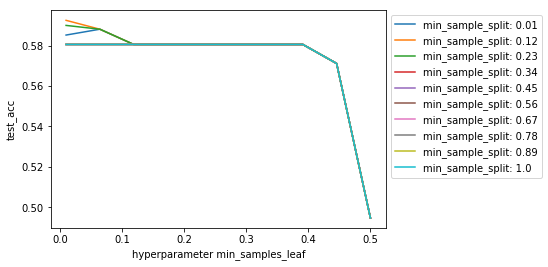

In [136]:
df = pd.DataFrame(res_dict)
df.plot()
plt.xlabel("hyperparameter min_samples_leaf")
plt.ylabel("test_acc")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### not too much variation for min_samples_leaf between 0.1 and 0.5, let's re test with a finer grid

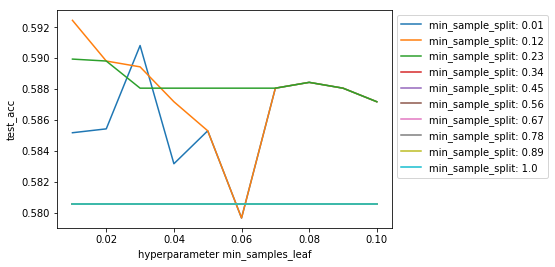

In [138]:
min_samples_split_values = np.linspace(0.01, 1.0, 10)
min_samples_leaf_values = np.linspace(0.01, 0.1, 10)

res_dict = {}
for ss, sl in itertools.product(min_samples_split_values, min_samples_leaf_values):
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=ss, min_samples_leaf=sl)
    clf.fit(X, Y)
    test_acc = test_model_acc(clf)
    if 'min_sample_split: %s' % ss in res_dict.keys():
        res_dict['min_sample_split: %s' % ss][sl] = test_acc
    else:
        res_dict['min_sample_split: %s' % ss] = {sl:test_acc}
        
df = pd.DataFrame(res_dict)
df.plot()
plt.xlabel("hyperparameter min_samples_leaf")
plt.ylabel("test_acc")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### looking at the 3 lines at the top, there seems to be a max some where between min_sample_splot (0.01, 0.23)

let's zoom in:

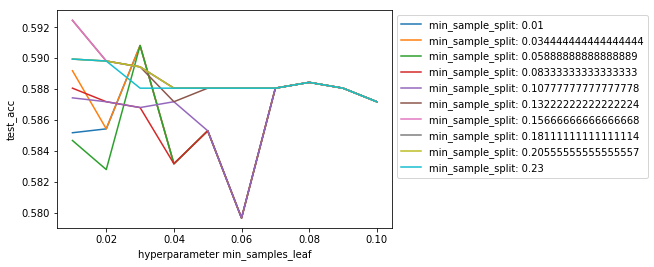

In [139]:
min_samples_split_values = np.linspace(0.01, 0.23, 10)
min_samples_leaf_values = np.linspace(0.01, 0.1, 10)

res_dict = {}
for ss, sl in itertools.product(min_samples_split_values, min_samples_leaf_values):
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=ss, min_samples_leaf=sl)
    clf.fit(X, Y)
    test_acc = test_model_acc(clf)
    if 'min_sample_split: %s' % ss in res_dict.keys():
        res_dict['min_sample_split: %s' % ss][sl] = test_acc
    else:
        res_dict['min_sample_split: %s' % ss] = {sl:test_acc}
        
df = pd.DataFrame(res_dict)
df.plot()
plt.xlabel("hyperparameter min_samples_leaf")
plt.ylabel("test_acc")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [142]:
df

,min_sample_split: 0.01,min_sample_split: 0.034444444444444444,min_sample_split: 0.05888888888888889,min_sample_split: 0.08333333333333333,min_sample_split: 0.10777777777777778,min_sample_split: 0.13222222222222224,min_sample_split: 0.15666666666666668,min_sample_split: 0.18111111111111114,min_sample_split: 0.20555555555555557,min_sample_split: 0.23
0.01,0.585173,0.589187,0.584671,0.588058,0.587431,0.592449,0.592449,0.589940,0.589940,0.589940
0.02,0.585424,0.585424,0.582790,0.587180,0.587180,0.589814,0.589814,0.589814,0.589814,0.589814
0.03,0.590818,0.590818,0.590818,0.586804,0.586804,0.589438,0.589438,0.589438,0.589438,0.588058
0.04,0.583166,0.583166,0.583166,0.583166,0.587180,0.587180,0.588058,0.588058,0.588058,0.588058
0.05,0.585299,0.585299,0.585299,0.585299,0.585299,0.588058,0.588058,0.588058,0.588058,0.588058
0.06,0.579654,0.579654,0.579654,0.579654,0.579654,0.588058,0.588058,0.588058,0.588058,0.588058
0.07,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058
0.08,0.588435,0.588435,0.588435,0.588435,0.588435,0.588435,0.588435,0.588435,0.588435,0.588435
0.09,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058,0.588058
0.10,0.587180,0.587180,0.587180,0.587180,0.587180,0.587180,0.587180,0.587180,0.587180,0.587180


max is around min_sample_split: (0.1, 0.18) and min_sample_leaf (0.00, 0.02)

let's zoom in 1 last time

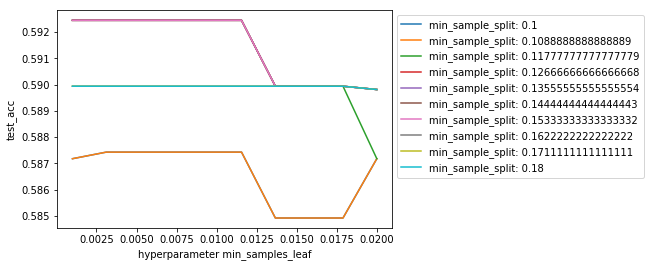

In [143]:
min_samples_split_values = np.linspace(0.1, 0.18, 10)
min_samples_leaf_values = np.linspace(0.001, 0.02, 10)

res_dict = {}
for ss, sl in itertools.product(min_samples_split_values, min_samples_leaf_values):
    clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=ss, min_samples_leaf=sl)
    clf.fit(X, Y)
    test_acc = test_model_acc(clf)
    if 'min_sample_split: %s' % ss in res_dict.keys():
        res_dict['min_sample_split: %s' % ss][sl] = test_acc
    else:
        res_dict['min_sample_split: %s' % ss] = {sl:test_acc}
        
df = pd.DataFrame(res_dict)
df.plot()
plt.xlabel("hyperparameter min_samples_leaf")
plt.ylabel("test_acc")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [144]:
df

,min_sample_split: 0.1,min_sample_split: 0.1088888888888889,min_sample_split: 0.11777777777777779,min_sample_split: 0.12666666666666668,min_sample_split: 0.13555555555555554,min_sample_split: 0.14444444444444443,min_sample_split: 0.15333333333333332,min_sample_split: 0.1622222222222222,min_sample_split: 0.1711111111111111,min_sample_split: 0.18
0.001000,0.587180,0.587180,0.592449,0.592449,0.592449,0.592449,0.592449,0.589940,0.589940,0.589940
0.003111,0.587431,0.587431,0.592449,0.592449,0.592449,0.592449,0.592449,0.589940,0.589940,0.589940
0.005222,0.587431,0.587431,0.592449,0.592449,0.592449,0.592449,0.592449,0.589940,0.589940,0.589940
0.007333,0.587431,0.587431,0.592449,0.592449,0.592449,0.592449,0.592449,0.589940,0.589940,0.589940
0.009444,0.587431,0.587431,0.592449,0.592449,0.592449,0.592449,0.592449,0.589940,0.589940,0.589940
0.011556,0.587431,0.587431,0.592449,0.592449,0.592449,0.592449,0.592449,0.589940,0.589940,0.589940
0.013667,0.584922,0.584922,0.589940,0.589940,0.589940,0.589940,0.589940,0.589940,0.589940,0.589940
0.015778,0.584922,0.584922,0.589940,0.589940,0.589940,0.589940,0.589940,0.589940,0.589940,0.589940
0.017889,0.584922,0.584922,0.589940,0.589940,0.589940,0.589940,0.589940,0.589940,0.589940,0.589940
0.020000,0.587180,0.587180,0.587180,0.589814,0.589814,0.589814,0.589814,0.589814,0.589814,0.589814


4\. Which configuration returns the best accuracy? What is this accuracy? (Note, if you don't see much variation in the test set accuracy across values of min_samples_split or min_samples_leaf, try redoing the above steps with a different range of values), and reassess your answer in Q3.2.

Looks like we can't really do better than 59.2% at various combinations of the 2 hyperparameters as indicated in the table above.

an example would be: 
- min_sample_split = 0.1355 * datasize
- min_sample_leaf = 0.00311 * datasize


5\. If you were working for a marketing department, how would you use your churn production model in a real business environment? Explain why churn prediction might be good for the business and how one might improve churn by using this model.

If we can get a model that can help with predicting when a customer has a higher likeihood of churn, we can create workflows that help us more effectively target that customer to help us retain them.

If the model can provide enough recall, then the cost of the additional retention workflow can be less than the expected benefits of retaining that customer and as a result add business value.